# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import random
import sys
import os
import logging

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import optuna

from collections import Counter
from typing import Optional

from sklearn.metrics import mean_absolute_error, mean_squared_error

sys.path.append("../../src")
sys.path.append("../palm-tree")

import embedder
import models
import utils
import train
import dataset

In [2]:
torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

device(type='cuda', index=1)

# Data

In [3]:
data_files = os.listdir("../../dataset/bb_data/")

if "good_dataset.pkl" not in data_files:
    result_files = [f for f in os.listdir("../../../good_dataset/") if f.endswith("results")] 
    data_df = pd.DataFrame()

    for file in result_files:
        file_df = utils.read_bb_data(f"../../../good_dataset/{file}/breaker_code.txt", f"../../../good_dataset/{file}/breaker_final_energy.txt")
        file_df = utils.preprocess_bb_df(file_df)
        data_df = pd.concat([data_df, file_df], ignore_index=True)

    data_df.to_pickle("../../dataset/bb_data/good_dataset.pkl")
    
else:
    data_df = pd.read_pickle("../../dataset/bb_data/good_dataset.pkl")
    if "bb_embeddings" in data_df.columns:
        data_df = data_df.drop(columns="bb_embeddings")

We create the vocab and tokenize the data

In [4]:
counts = Counter(inst for bb in data_df.bb.tolist() for inst in set(bb))

vocab = {inst: i for i, (inst, _) in enumerate(counts.most_common(20000), start=2)}
vocab["PAD"] = 0
vocab["UNK"] = 1

print(f"size of vocabulary: {len(vocab)}")

size of vocabulary: 1610


We remove outliers in order to have more balanced padded sequences

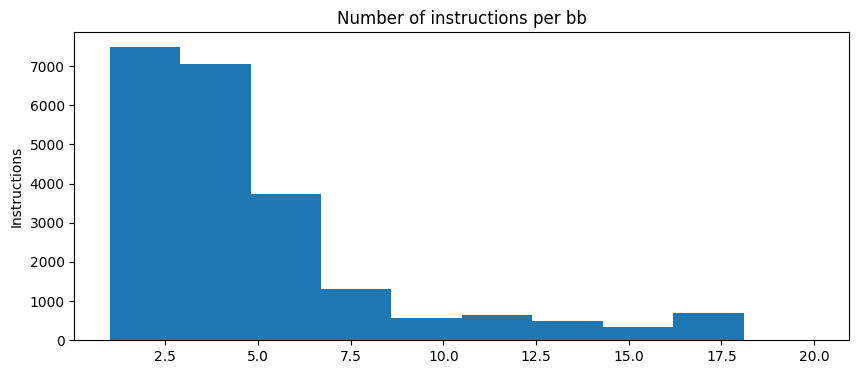

In [5]:
plt.figure(figsize=(10,4))
plt.hist(data_df.bb.map(len))
plt.title("Number of instructions per bb")
plt.ylabel("Instructions")
plt.show()

In [6]:
data_df["encoded_bb"] = data_df.bb.apply(lambda x: utils.encode_bb_from_vocab(x, vocab, max_insts=20))
data_df.head(10)

,bb,energy,encoded_bb
0,[movl $0x0],0.645165,[31]
1,"[callq, pushq %rbp, mov %rsp %rbp]",2.910575,"[7, 14, 499]"
2,"[popq %rbp, retq]",0.997157,"[9, 6]"
3,[movl $0x0],0.664772,[31]
4,"[cmpl $0x64, jnl 0x2c]",1.400952,"[408, 407]"
5,"[movl %eax, imull %eax, add $0x9 %eax, movsxdl...",2.334921,"[2, 397, 410, 29, 2]"
6,"[movl %eax, add $0x1 %eax, movl %eax, jmp]",2.419369,"[2, 30, 2, 4]"
7,"[cmpl $0x64, jnl 0x2c]",0.967748,"[408, 407]"
8,"[movl %eax, imull %eax, add $0x9 %eax, movsxdl...",1.612913,"[2, 397, 410, 29, 2]"
9,"[movl %eax, add $0x1 %eax, movl %eax, jmp]",2.419369,"[2, 30, 2, 4]"


# Optuna Trials

In [14]:
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "lstm-vocab-regression-study-good-dataset"
storage_name = f"sqlite:////Users/thodo/Documents/sxoli/diplomatiki/optuna-studies/lstm-vocab-regression-study.db"
study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True, direction="minimize")
study.set_user_attr("Loss", "RMSE")
study.set_user_attr("Special vocab tokens", "['unk': 0, 'pad': 1]")
study.set_user_attr("Max instructions", "20")

[I 2023-01-15 17:07:00,015] A new study created in RDB with name: lstm-vocab-regression-study-good-dataset


A new study created in RDB with name: lstm-vocab-regression-study-good-dataset


In [15]:
def objective(trial):

    embedding_size = trial.suggest_int("embedding_size", 64, 512)
    lstm_layers = trial.suggest_int("lstm_layers", 1, 5)
    hidden_size = trial.suggest_int("hidden_size", 8, 128)
    dense_size = trial.suggest_int("dense_size", 16, 256)
    smaller_dense_size = trial.suggest_int("smaller_dense_size", 8, 64)
    batch_size_exp = trial.suggest_int("batch_size_exp", 3, 7)
    lstm_dropout = trial.suggest_float("lstm_dropout", 0, 0.2)
    regressor_dropout = trial.suggest_float("regressor_dropout", 0, 0.15)
    lr = trial.suggest_float("lr", 1e-4, 1e-2)
    lr_decay = trial.suggest_float("lr_decay", 0.05, 0.8)
    lr_decay_step = trial.suggest_int("lr_decay_step", 5, 20)

    batch_size = 2**batch_size_exp

    data_loaders = utils.get_vocab_data_dict(data_df=data_df, batch_size=batch_size)
    train_loader = data_loaders["train_loader"]
    val_loader = data_loaders["val_loader"]

    model = models.LSTM_Regressor(
        vocab_size=len(vocab),
        embedding_size=embedding_size,
        custom_embs=True,
        hidden_size=hidden_size,
        num_layers=lstm_layers,
        dense_size=dense_size,
        smaller_dense_size=smaller_dense_size,
        lstm_dropout=lstm_dropout,
        regressor_dropout=regressor_dropout,
    )
    train_results = train.train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        lr=lr,
        epochs=200,
        batch_size=batch_size,
        early_stopping=True,
        lr_decay=lr_decay,
        lr_decay_step=lr_decay_step,
    )

    val_loss = train_results["val_loss"]

    return val_loss[-1]


study.optimize(objective, n_trials=120)

[I 2023-01-15 17:10:46,780] Trial 0 finished with value: 0.4593201525833296 and parameters: {'embedding_size': 500, 'lstm_layers': 5, 'hidden_size': 105, 'dense_size': 227, 'smaller_dense_size': 14, 'batch_size_exp': 5, 'lr': 0.008246124138325102, 'lstm_dropout': 0.15713575441199168, 'regressor_dropout': 0.023881148360199084, 'lr_decay': 0.24842666413263959, 'lr_decay_step': 5}. Best is trial 0 with value: 0.4593201525833296.


Trial 0 finished with value: 0.4593201525833296 and parameters: {'embedding_size': 500, 'lstm_layers': 5, 'hidden_size': 105, 'dense_size': 227, 'smaller_dense_size': 14, 'batch_size_exp': 5, 'lr': 0.008246124138325102, 'lstm_dropout': 0.15713575441199168, 'regressor_dropout': 0.023881148360199084, 'lr_decay': 0.24842666413263959, 'lr_decay_step': 5}. Best is trial 0 with value: 0.4593201525833296.


[I 2023-01-15 17:26:35,267] Trial 1 finished with value: 0.3909755822898667 and parameters: {'embedding_size': 416, 'lstm_layers': 2, 'hidden_size': 55, 'dense_size': 26, 'smaller_dense_size': 19, 'batch_size_exp': 3, 'lr': 0.009624102607186227, 'lstm_dropout': 0.05459941834509596, 'regressor_dropout': 0.07971817762229645, 'lr_decay': 0.7176430884613356, 'lr_decay_step': 14}. Best is trial 1 with value: 0.3909755822898667.


Trial 1 finished with value: 0.3909755822898667 and parameters: {'embedding_size': 416, 'lstm_layers': 2, 'hidden_size': 55, 'dense_size': 26, 'smaller_dense_size': 19, 'batch_size_exp': 3, 'lr': 0.009624102607186227, 'lstm_dropout': 0.05459941834509596, 'regressor_dropout': 0.07971817762229645, 'lr_decay': 0.7176430884613356, 'lr_decay_step': 14}. Best is trial 1 with value: 0.3909755822898667.


[I 2023-01-15 17:30:07,798] Trial 2 finished with value: 0.4362978991391002 and parameters: {'embedding_size': 406, 'lstm_layers': 5, 'hidden_size': 25, 'dense_size': 121, 'smaller_dense_size': 22, 'batch_size_exp': 5, 'lr': 0.008561960847832993, 'lstm_dropout': 0.014823177677943257, 'regressor_dropout': 0.06566412020124218, 'lr_decay': 0.7199142822341618, 'lr_decay_step': 13}. Best is trial 1 with value: 0.3909755822898667.


Trial 2 finished with value: 0.4362978991391002 and parameters: {'embedding_size': 406, 'lstm_layers': 5, 'hidden_size': 25, 'dense_size': 121, 'smaller_dense_size': 22, 'batch_size_exp': 5, 'lr': 0.008561960847832993, 'lstm_dropout': 0.014823177677943257, 'regressor_dropout': 0.06566412020124218, 'lr_decay': 0.7199142822341618, 'lr_decay_step': 13}. Best is trial 1 with value: 0.3909755822898667.


[I 2023-01-15 17:31:12,759] Trial 3 finished with value: 0.49683916568756104 and parameters: {'embedding_size': 74, 'lstm_layers': 4, 'hidden_size': 53, 'dense_size': 21, 'smaller_dense_size': 36, 'batch_size_exp': 7, 'lr': 0.002111729129665572, 'lstm_dropout': 0.16581135107250955, 'regressor_dropout': 0.12262767656849108, 'lr_decay': 0.23544034458596652, 'lr_decay_step': 11}. Best is trial 1 with value: 0.3909755822898667.


Trial 3 finished with value: 0.49683916568756104 and parameters: {'embedding_size': 74, 'lstm_layers': 4, 'hidden_size': 53, 'dense_size': 21, 'smaller_dense_size': 36, 'batch_size_exp': 7, 'lr': 0.002111729129665572, 'lstm_dropout': 0.16581135107250955, 'regressor_dropout': 0.12262767656849108, 'lr_decay': 0.23544034458596652, 'lr_decay_step': 11}. Best is trial 1 with value: 0.3909755822898667.


[I 2023-01-15 17:40:27,002] Trial 4 finished with value: 0.7105451354416468 and parameters: {'embedding_size': 72, 'lstm_layers': 5, 'hidden_size': 107, 'dense_size': 46, 'smaller_dense_size': 45, 'batch_size_exp': 3, 'lr': 0.008787679801909337, 'lstm_dropout': 0.06482871522869726, 'regressor_dropout': 0.008582875246776905, 'lr_decay': 0.5565283607543403, 'lr_decay_step': 19}. Best is trial 1 with value: 0.3909755822898667.


Trial 4 finished with value: 0.7105451354416468 and parameters: {'embedding_size': 72, 'lstm_layers': 5, 'hidden_size': 107, 'dense_size': 46, 'smaller_dense_size': 45, 'batch_size_exp': 3, 'lr': 0.008787679801909337, 'lstm_dropout': 0.06482871522869726, 'regressor_dropout': 0.008582875246776905, 'lr_decay': 0.5565283607543403, 'lr_decay_step': 19}. Best is trial 1 with value: 0.3909755822898667.


[I 2023-01-15 17:42:36,325] Trial 5 finished with value: 0.43544740370218304 and parameters: {'embedding_size': 82, 'lstm_layers': 2, 'hidden_size': 21, 'dense_size': 77, 'smaller_dense_size': 49, 'batch_size_exp': 5, 'lr': 0.002054866672667911, 'lstm_dropout': 0.1170744136438302, 'regressor_dropout': 0.10556835647982492, 'lr_decay': 0.47534473643721437, 'lr_decay_step': 18}. Best is trial 1 with value: 0.3909755822898667.


Trial 5 finished with value: 0.43544740370218304 and parameters: {'embedding_size': 82, 'lstm_layers': 2, 'hidden_size': 21, 'dense_size': 77, 'smaller_dense_size': 49, 'batch_size_exp': 5, 'lr': 0.002054866672667911, 'lstm_dropout': 0.1170744136438302, 'regressor_dropout': 0.10556835647982492, 'lr_decay': 0.47534473643721437, 'lr_decay_step': 18}. Best is trial 1 with value: 0.3909755822898667.


[I 2023-01-15 17:43:16,137] Trial 6 finished with value: 0.5461477093836841 and parameters: {'embedding_size': 289, 'lstm_layers': 1, 'hidden_size': 46, 'dense_size': 27, 'smaller_dense_size': 31, 'batch_size_exp': 7, 'lr': 0.00024566539717572997, 'lstm_dropout': 0.08676863288435802, 'regressor_dropout': 0.12317283576328635, 'lr_decay': 0.19207938214320042, 'lr_decay_step': 11}. Best is trial 1 with value: 0.3909755822898667.


Trial 6 finished with value: 0.5461477093836841 and parameters: {'embedding_size': 289, 'lstm_layers': 1, 'hidden_size': 46, 'dense_size': 27, 'smaller_dense_size': 31, 'batch_size_exp': 7, 'lr': 0.00024566539717572997, 'lstm_dropout': 0.08676863288435802, 'regressor_dropout': 0.12317283576328635, 'lr_decay': 0.19207938214320042, 'lr_decay_step': 11}. Best is trial 1 with value: 0.3909755822898667.


[I 2023-01-15 17:43:51,646] Trial 7 finished with value: 0.5511742514722487 and parameters: {'embedding_size': 180, 'lstm_layers': 5, 'hidden_size': 20, 'dense_size': 191, 'smaller_dense_size': 39, 'batch_size_exp': 7, 'lr': 0.0059357605987710995, 'lstm_dropout': 0.02903898334010198, 'regressor_dropout': 0.08701071236135414, 'lr_decay': 0.4197525232462334, 'lr_decay_step': 8}. Best is trial 1 with value: 0.3909755822898667.


Trial 7 finished with value: 0.5511742514722487 and parameters: {'embedding_size': 180, 'lstm_layers': 5, 'hidden_size': 20, 'dense_size': 191, 'smaller_dense_size': 39, 'batch_size_exp': 7, 'lr': 0.0059357605987710995, 'lstm_dropout': 0.02903898334010198, 'regressor_dropout': 0.08701071236135414, 'lr_decay': 0.4197525232462334, 'lr_decay_step': 8}. Best is trial 1 with value: 0.3909755822898667.


[I 2023-01-15 17:51:46,635] Trial 8 finished with value: 0.4790549374741616 and parameters: {'embedding_size': 92, 'lstm_layers': 5, 'hidden_size': 27, 'dense_size': 213, 'smaller_dense_size': 31, 'batch_size_exp': 4, 'lr': 0.0017127002383072192, 'lstm_dropout': 0.13213444516899084, 'regressor_dropout': 0.002873978024102858, 'lr_decay': 0.3537724272034197, 'lr_decay_step': 20}. Best is trial 1 with value: 0.3909755822898667.


Trial 8 finished with value: 0.4790549374741616 and parameters: {'embedding_size': 92, 'lstm_layers': 5, 'hidden_size': 27, 'dense_size': 213, 'smaller_dense_size': 31, 'batch_size_exp': 4, 'lr': 0.0017127002383072192, 'lstm_dropout': 0.13213444516899084, 'regressor_dropout': 0.002873978024102858, 'lr_decay': 0.3537724272034197, 'lr_decay_step': 20}. Best is trial 1 with value: 0.3909755822898667.


[I 2023-01-15 17:52:14,032] Trial 9 finished with value: 0.518042720416013 and parameters: {'embedding_size': 451, 'lstm_layers': 1, 'hidden_size': 91, 'dense_size': 100, 'smaller_dense_size': 20, 'batch_size_exp': 7, 'lr': 0.0095584707049445, 'lstm_dropout': 0.1986913212758246, 'regressor_dropout': 0.10557229673826714, 'lr_decay': 0.20383873981593864, 'lr_decay_step': 9}. Best is trial 1 with value: 0.3909755822898667.


Trial 9 finished with value: 0.518042720416013 and parameters: {'embedding_size': 451, 'lstm_layers': 1, 'hidden_size': 91, 'dense_size': 100, 'smaller_dense_size': 20, 'batch_size_exp': 7, 'lr': 0.0095584707049445, 'lstm_dropout': 0.1986913212758246, 'regressor_dropout': 0.10557229673826714, 'lr_decay': 0.20383873981593864, 'lr_decay_step': 9}. Best is trial 1 with value: 0.3909755822898667.


[I 2023-01-15 18:02:20,338] Trial 10 finished with value: 0.38408319467818863 and parameters: {'embedding_size': 338, 'lstm_layers': 3, 'hidden_size': 74, 'dense_size': 161, 'smaller_dense_size': 62, 'batch_size_exp': 3, 'lr': 0.006126809435667172, 'lstm_dropout': 0.05359889769357721, 'regressor_dropout': 0.06735872396037307, 'lr_decay': 0.7893678976085307, 'lr_decay_step': 15}. Best is trial 10 with value: 0.38408319467818863.


Trial 10 finished with value: 0.38408319467818863 and parameters: {'embedding_size': 338, 'lstm_layers': 3, 'hidden_size': 74, 'dense_size': 161, 'smaller_dense_size': 62, 'batch_size_exp': 3, 'lr': 0.006126809435667172, 'lstm_dropout': 0.05359889769357721, 'regressor_dropout': 0.06735872396037307, 'lr_decay': 0.7893678976085307, 'lr_decay_step': 15}. Best is trial 10 with value: 0.38408319467818863.


[I 2023-01-15 18:13:06,059] Trial 11 finished with value: 0.4159332609278113 and parameters: {'embedding_size': 334, 'lstm_layers': 3, 'hidden_size': 77, 'dense_size': 169, 'smaller_dense_size': 64, 'batch_size_exp': 3, 'lr': 0.005669128683764197, 'lstm_dropout': 0.049400247842415354, 'regressor_dropout': 0.058466708283383906, 'lr_decay': 0.7733293640825403, 'lr_decay_step': 15}. Best is trial 10 with value: 0.38408319467818863.


Trial 11 finished with value: 0.4159332609278113 and parameters: {'embedding_size': 334, 'lstm_layers': 3, 'hidden_size': 77, 'dense_size': 169, 'smaller_dense_size': 64, 'batch_size_exp': 3, 'lr': 0.005669128683764197, 'lstm_dropout': 0.049400247842415354, 'regressor_dropout': 0.058466708283383906, 'lr_decay': 0.7733293640825403, 'lr_decay_step': 15}. Best is trial 10 with value: 0.38408319467818863.


[I 2023-01-15 18:20:14,587] Trial 12 finished with value: 0.42561033432432216 and parameters: {'embedding_size': 355, 'lstm_layers': 3, 'hidden_size': 68, 'dense_size': 152, 'smaller_dense_size': 63, 'batch_size_exp': 4, 'lr': 0.0069390616675837295, 'lstm_dropout': 0.0767017613810233, 'regressor_dropout': 0.0498460593177808, 'lr_decay': 0.6574947969150828, 'lr_decay_step': 16}. Best is trial 10 with value: 0.38408319467818863.


Trial 12 finished with value: 0.42561033432432216 and parameters: {'embedding_size': 355, 'lstm_layers': 3, 'hidden_size': 68, 'dense_size': 152, 'smaller_dense_size': 63, 'batch_size_exp': 4, 'lr': 0.0069390616675837295, 'lstm_dropout': 0.0767017613810233, 'regressor_dropout': 0.0498460593177808, 'lr_decay': 0.6574947969150828, 'lr_decay_step': 16}. Best is trial 10 with value: 0.38408319467818863.


[I 2023-01-15 18:28:33,656] Trial 13 finished with value: 0.39874339810702747 and parameters: {'embedding_size': 237, 'lstm_layers': 2, 'hidden_size': 55, 'dense_size': 72, 'smaller_dense_size': 8, 'batch_size_exp': 3, 'lr': 0.007102092262947421, 'lstm_dropout': 0.04194900472869733, 'regressor_dropout': 0.0393619470087075, 'lr_decay': 0.6210066545065993, 'lr_decay_step': 15}. Best is trial 10 with value: 0.38408319467818863.


Trial 13 finished with value: 0.39874339810702747 and parameters: {'embedding_size': 237, 'lstm_layers': 2, 'hidden_size': 55, 'dense_size': 72, 'smaller_dense_size': 8, 'batch_size_exp': 3, 'lr': 0.007102092262947421, 'lstm_dropout': 0.04194900472869733, 'regressor_dropout': 0.0393619470087075, 'lr_decay': 0.6210066545065993, 'lr_decay_step': 15}. Best is trial 10 with value: 0.38408319467818863.


[I 2023-01-15 18:33:08,804] Trial 14 finished with value: 0.4652764417981501 and parameters: {'embedding_size': 384, 'lstm_layers': 2, 'hidden_size': 124, 'dense_size': 133, 'smaller_dense_size': 53, 'batch_size_exp': 4, 'lr': 0.00434251962414892, 'lstm_dropout': 0.010014267500196974, 'regressor_dropout': 0.08237709123946697, 'lr_decay': 0.06229535367164618, 'lr_decay_step': 13}. Best is trial 10 with value: 0.38408319467818863.


Trial 14 finished with value: 0.4652764417981501 and parameters: {'embedding_size': 384, 'lstm_layers': 2, 'hidden_size': 124, 'dense_size': 133, 'smaller_dense_size': 53, 'batch_size_exp': 4, 'lr': 0.00434251962414892, 'lstm_dropout': 0.010014267500196974, 'regressor_dropout': 0.08237709123946697, 'lr_decay': 0.06229535367164618, 'lr_decay_step': 13}. Best is trial 10 with value: 0.38408319467818863.


[I 2023-01-15 18:49:38,745] Trial 15 finished with value: 0.4007242549491185 and parameters: {'embedding_size': 447, 'lstm_layers': 4, 'hidden_size': 83, 'dense_size': 188, 'smaller_dense_size': 56, 'batch_size_exp': 3, 'lr': 0.004100514090172798, 'lstm_dropout': 0.10217838780711225, 'regressor_dropout': 0.09355888442271842, 'lr_decay': 0.7903028085054988, 'lr_decay_step': 16}. Best is trial 10 with value: 0.38408319467818863.


Trial 15 finished with value: 0.4007242549491185 and parameters: {'embedding_size': 447, 'lstm_layers': 4, 'hidden_size': 83, 'dense_size': 188, 'smaller_dense_size': 56, 'batch_size_exp': 3, 'lr': 0.004100514090172798, 'lstm_dropout': 0.10217838780711225, 'regressor_dropout': 0.09355888442271842, 'lr_decay': 0.7903028085054988, 'lr_decay_step': 16}. Best is trial 10 with value: 0.38408319467818863.


[I 2023-01-15 18:52:44,864] Trial 16 finished with value: 0.44556167335818997 and parameters: {'embedding_size': 288, 'lstm_layers': 2, 'hidden_size': 40, 'dense_size': 251, 'smaller_dense_size': 21, 'batch_size_exp': 4, 'lr': 0.007279215210793598, 'lstm_dropout': 0.05647927169316584, 'regressor_dropout': 0.14823543228481628, 'lr_decay': 0.5534880136737759, 'lr_decay_step': 17}. Best is trial 10 with value: 0.38408319467818863.


Trial 16 finished with value: 0.44556167335818997 and parameters: {'embedding_size': 288, 'lstm_layers': 2, 'hidden_size': 40, 'dense_size': 251, 'smaller_dense_size': 21, 'batch_size_exp': 4, 'lr': 0.007279215210793598, 'lstm_dropout': 0.05647927169316584, 'regressor_dropout': 0.14823543228481628, 'lr_decay': 0.5534880136737759, 'lr_decay_step': 17}. Best is trial 10 with value: 0.38408319467818863.


[I 2023-01-15 18:53:56,716] Trial 17 finished with value: 0.5111131036982817 and parameters: {'embedding_size': 314, 'lstm_layers': 3, 'hidden_size': 63, 'dense_size': 106, 'smaller_dense_size': 28, 'batch_size_exp': 6, 'lr': 0.003413920731499079, 'lstm_dropout': 0.0009685749604488314, 'regressor_dropout': 0.03764241608965119, 'lr_decay': 0.7008687482909304, 'lr_decay_step': 14}. Best is trial 10 with value: 0.38408319467818863.


Trial 17 finished with value: 0.5111131036982817 and parameters: {'embedding_size': 314, 'lstm_layers': 3, 'hidden_size': 63, 'dense_size': 106, 'smaller_dense_size': 28, 'batch_size_exp': 6, 'lr': 0.003413920731499079, 'lstm_dropout': 0.0009685749604488314, 'regressor_dropout': 0.03764241608965119, 'lr_decay': 0.7008687482909304, 'lr_decay_step': 14}. Best is trial 10 with value: 0.38408319467818863.


[I 2023-01-15 19:07:15,236] Trial 18 finished with value: 0.3776194057210372 and parameters: {'embedding_size': 224, 'lstm_layers': 4, 'hidden_size': 38, 'dense_size': 159, 'smaller_dense_size': 42, 'batch_size_exp': 3, 'lr': 0.009694473655230323, 'lstm_dropout': 0.03146350735999125, 'regressor_dropout': 0.06821092486370066, 'lr_decay': 0.5995695618328347, 'lr_decay_step': 11}. Best is trial 18 with value: 0.3776194057210372.


Trial 18 finished with value: 0.3776194057210372 and parameters: {'embedding_size': 224, 'lstm_layers': 4, 'hidden_size': 38, 'dense_size': 159, 'smaller_dense_size': 42, 'batch_size_exp': 3, 'lr': 0.009694473655230323, 'lstm_dropout': 0.03146350735999125, 'regressor_dropout': 0.06821092486370066, 'lr_decay': 0.5995695618328347, 'lr_decay_step': 11}. Best is trial 18 with value: 0.3776194057210372.


[I 2023-01-15 19:08:26,808] Trial 19 finished with value: 0.48321279225980535 and parameters: {'embedding_size': 186, 'lstm_layers': 4, 'hidden_size': 35, 'dense_size': 157, 'smaller_dense_size': 42, 'batch_size_exp': 6, 'lr': 0.005264310825947889, 'lstm_dropout': 0.03153208728120597, 'regressor_dropout': 0.06781549391858424, 'lr_decay': 0.5799701973981235, 'lr_decay_step': 11}. Best is trial 18 with value: 0.3776194057210372.


Trial 19 finished with value: 0.48321279225980535 and parameters: {'embedding_size': 186, 'lstm_layers': 4, 'hidden_size': 35, 'dense_size': 157, 'smaller_dense_size': 42, 'batch_size_exp': 6, 'lr': 0.005264310825947889, 'lstm_dropout': 0.03153208728120597, 'regressor_dropout': 0.06781549391858424, 'lr_decay': 0.5799701973981235, 'lr_decay_step': 11}. Best is trial 18 with value: 0.3776194057210372.


[I 2023-01-15 19:15:25,745] Trial 20 finished with value: 0.4038155628301257 and parameters: {'embedding_size': 228, 'lstm_layers': 4, 'hidden_size': 97, 'dense_size': 193, 'smaller_dense_size': 57, 'batch_size_exp': 4, 'lr': 0.007750969336780496, 'lstm_dropout': 0.08603628493314844, 'regressor_dropout': 0.052632834161482796, 'lr_decay': 0.4665407755907581, 'lr_decay_step': 8}. Best is trial 18 with value: 0.3776194057210372.


Trial 20 finished with value: 0.4038155628301257 and parameters: {'embedding_size': 228, 'lstm_layers': 4, 'hidden_size': 97, 'dense_size': 193, 'smaller_dense_size': 57, 'batch_size_exp': 4, 'lr': 0.007750969336780496, 'lstm_dropout': 0.08603628493314844, 'regressor_dropout': 0.052632834161482796, 'lr_decay': 0.4665407755907581, 'lr_decay_step': 8}. Best is trial 18 with value: 0.3776194057210372.


[I 2023-01-15 19:26:03,462] Trial 21 finished with value: 0.3636768703819603 and parameters: {'embedding_size': 242, 'lstm_layers': 3, 'hidden_size': 8, 'dense_size': 145, 'smaller_dense_size': 50, 'batch_size_exp': 3, 'lr': 0.009710906674057183, 'lstm_dropout': 0.0665692828884658, 'regressor_dropout': 0.07477400198939368, 'lr_decay': 0.7053868976485915, 'lr_decay_step': 12}. Best is trial 21 with value: 0.3636768703819603.


Trial 21 finished with value: 0.3636768703819603 and parameters: {'embedding_size': 242, 'lstm_layers': 3, 'hidden_size': 8, 'dense_size': 145, 'smaller_dense_size': 50, 'batch_size_exp': 3, 'lr': 0.009710906674057183, 'lstm_dropout': 0.0665692828884658, 'regressor_dropout': 0.07477400198939368, 'lr_decay': 0.7053868976485915, 'lr_decay_step': 12}. Best is trial 21 with value: 0.3636768703819603.


[I 2023-01-15 19:39:01,262] Trial 22 finished with value: 0.36891884834749294 and parameters: {'embedding_size': 232, 'lstm_layers': 3, 'hidden_size': 10, 'dense_size': 144, 'smaller_dense_size': 48, 'batch_size_exp': 3, 'lr': 0.00992782110786866, 'lstm_dropout': 0.07111290632317113, 'regressor_dropout': 0.07166799131760718, 'lr_decay': 0.7940194430345509, 'lr_decay_step': 10}. Best is trial 21 with value: 0.3636768703819603.


Trial 22 finished with value: 0.36891884834749294 and parameters: {'embedding_size': 232, 'lstm_layers': 3, 'hidden_size': 10, 'dense_size': 144, 'smaller_dense_size': 48, 'batch_size_exp': 3, 'lr': 0.00992782110786866, 'lstm_dropout': 0.07111290632317113, 'regressor_dropout': 0.07166799131760718, 'lr_decay': 0.7940194430345509, 'lr_decay_step': 10}. Best is trial 21 with value: 0.3636768703819603.


[I 2023-01-15 19:57:33,106] Trial 23 finished with value: 0.4048944262246932 and parameters: {'embedding_size': 239, 'lstm_layers': 4, 'hidden_size': 8, 'dense_size': 126, 'smaller_dense_size': 47, 'batch_size_exp': 3, 'lr': 0.009502458687653705, 'lstm_dropout': 0.07400346927324178, 'regressor_dropout': 0.10209102105763396, 'lr_decay': 0.6396497269894509, 'lr_decay_step': 10}. Best is trial 21 with value: 0.3636768703819603.


Trial 23 finished with value: 0.4048944262246932 and parameters: {'embedding_size': 239, 'lstm_layers': 4, 'hidden_size': 8, 'dense_size': 126, 'smaller_dense_size': 47, 'batch_size_exp': 3, 'lr': 0.009502458687653705, 'lstm_dropout': 0.07400346927324178, 'regressor_dropout': 0.10209102105763396, 'lr_decay': 0.6396497269894509, 'lr_decay_step': 10}. Best is trial 21 with value: 0.3636768703819603.


[I 2023-01-15 20:04:39,302] Trial 24 finished with value: 0.38895427923408343 and parameters: {'embedding_size': 152, 'lstm_layers': 3, 'hidden_size': 9, 'dense_size': 142, 'smaller_dense_size': 53, 'batch_size_exp': 4, 'lr': 0.009866721618664517, 'lstm_dropout': 0.10316702440568434, 'regressor_dropout': 0.035698619427780576, 'lr_decay': 0.6890254998820042, 'lr_decay_step': 6}. Best is trial 21 with value: 0.3636768703819603.


Trial 24 finished with value: 0.38895427923408343 and parameters: {'embedding_size': 152, 'lstm_layers': 3, 'hidden_size': 9, 'dense_size': 142, 'smaller_dense_size': 53, 'batch_size_exp': 4, 'lr': 0.009866721618664517, 'lstm_dropout': 0.10316702440568434, 'regressor_dropout': 0.035698619427780576, 'lr_decay': 0.6890254998820042, 'lr_decay_step': 6}. Best is trial 21 with value: 0.3636768703819603.


[I 2023-01-15 20:18:37,031] Trial 25 finished with value: 0.3850038675557969 and parameters: {'embedding_size': 133, 'lstm_layers': 3, 'hidden_size': 15, 'dense_size': 172, 'smaller_dense_size': 42, 'batch_size_exp': 3, 'lr': 0.009024201945970018, 'lstm_dropout': 0.03296434928889553, 'regressor_dropout': 0.07430874984557646, 'lr_decay': 0.7437183265250413, 'lr_decay_step': 12}. Best is trial 21 with value: 0.3636768703819603.


Trial 25 finished with value: 0.3850038675557969 and parameters: {'embedding_size': 133, 'lstm_layers': 3, 'hidden_size': 15, 'dense_size': 172, 'smaller_dense_size': 42, 'batch_size_exp': 3, 'lr': 0.009024201945970018, 'lstm_dropout': 0.03296434928889553, 'regressor_dropout': 0.07430874984557646, 'lr_decay': 0.7437183265250413, 'lr_decay_step': 12}. Best is trial 21 with value: 0.3636768703819603.


[I 2023-01-15 20:26:20,637] Trial 26 finished with value: 0.4009605298528997 and parameters: {'embedding_size': 210, 'lstm_layers': 4, 'hidden_size': 34, 'dense_size': 96, 'smaller_dense_size': 49, 'batch_size_exp': 4, 'lr': 0.008020245265657472, 'lstm_dropout': 0.022976446726144302, 'regressor_dropout': 0.09152438192344203, 'lr_decay': 0.5896123219573223, 'lr_decay_step': 7}. Best is trial 21 with value: 0.3636768703819603.


Trial 26 finished with value: 0.4009605298528997 and parameters: {'embedding_size': 210, 'lstm_layers': 4, 'hidden_size': 34, 'dense_size': 96, 'smaller_dense_size': 49, 'batch_size_exp': 4, 'lr': 0.008020245265657472, 'lstm_dropout': 0.022976446726144302, 'regressor_dropout': 0.09152438192344203, 'lr_decay': 0.5896123219573223, 'lr_decay_step': 7}. Best is trial 21 with value: 0.3636768703819603.


[I 2023-01-15 20:39:39,827] Trial 27 finished with value: 0.35153762125627114 and parameters: {'embedding_size': 268, 'lstm_layers': 3, 'hidden_size': 31, 'dense_size': 214, 'smaller_dense_size': 37, 'batch_size_exp': 3, 'lr': 0.009013044781248208, 'lstm_dropout': 0.12040569205232185, 'regressor_dropout': 0.04827514054539975, 'lr_decay': 0.5068315493004608, 'lr_decay_step': 9}. Best is trial 27 with value: 0.35153762125627114.


Trial 27 finished with value: 0.35153762125627114 and parameters: {'embedding_size': 268, 'lstm_layers': 3, 'hidden_size': 31, 'dense_size': 214, 'smaller_dense_size': 37, 'batch_size_exp': 3, 'lr': 0.009013044781248208, 'lstm_dropout': 0.12040569205232185, 'regressor_dropout': 0.04827514054539975, 'lr_decay': 0.5068315493004608, 'lr_decay_step': 9}. Best is trial 27 with value: 0.35153762125627114.


[I 2023-01-15 20:41:11,259] Trial 28 finished with value: 0.4576317369937897 and parameters: {'embedding_size': 271, 'lstm_layers': 3, 'hidden_size': 14, 'dense_size': 219, 'smaller_dense_size': 35, 'batch_size_exp': 6, 'lr': 0.008752630752733252, 'lstm_dropout': 0.12712642731840001, 'regressor_dropout': 0.021884022836924005, 'lr_decay': 0.3478827298645078, 'lr_decay_step': 9}. Best is trial 27 with value: 0.35153762125627114.


Trial 28 finished with value: 0.4576317369937897 and parameters: {'embedding_size': 271, 'lstm_layers': 3, 'hidden_size': 14, 'dense_size': 219, 'smaller_dense_size': 35, 'batch_size_exp': 6, 'lr': 0.008752630752733252, 'lstm_dropout': 0.12712642731840001, 'regressor_dropout': 0.021884022836924005, 'lr_decay': 0.3478827298645078, 'lr_decay_step': 9}. Best is trial 27 with value: 0.35153762125627114.


[I 2023-01-15 20:46:27,885] Trial 29 finished with value: 0.40900484295628914 and parameters: {'embedding_size': 264, 'lstm_layers': 3, 'hidden_size': 28, 'dense_size': 251, 'smaller_dense_size': 58, 'batch_size_exp': 4, 'lr': 0.007925333832170565, 'lstm_dropout': 0.15272445965423997, 'regressor_dropout': 0.023893761809799755, 'lr_decay': 0.5232014835510903, 'lr_decay_step': 5}. Best is trial 27 with value: 0.35153762125627114.


Trial 29 finished with value: 0.40900484295628914 and parameters: {'embedding_size': 264, 'lstm_layers': 3, 'hidden_size': 28, 'dense_size': 251, 'smaller_dense_size': 58, 'batch_size_exp': 4, 'lr': 0.007925333832170565, 'lstm_dropout': 0.15272445965423997, 'regressor_dropout': 0.023893761809799755, 'lr_decay': 0.5232014835510903, 'lr_decay_step': 5}. Best is trial 27 with value: 0.35153762125627114.


[I 2023-01-15 20:56:32,627] Trial 30 finished with value: 0.3301598468535049 and parameters: {'embedding_size': 132, 'lstm_layers': 2, 'hidden_size': 16, 'dense_size': 233, 'smaller_dense_size': 37, 'batch_size_exp': 3, 'lr': 0.006598201505269957, 'lstm_dropout': 0.14697752897247743, 'regressor_dropout': 0.045875966164498225, 'lr_decay': 0.6664477826529577, 'lr_decay_step': 9}. Best is trial 30 with value: 0.3301598468535049.


Trial 30 finished with value: 0.3301598468535049 and parameters: {'embedding_size': 132, 'lstm_layers': 2, 'hidden_size': 16, 'dense_size': 233, 'smaller_dense_size': 37, 'batch_size_exp': 3, 'lr': 0.006598201505269957, 'lstm_dropout': 0.14697752897247743, 'regressor_dropout': 0.045875966164498225, 'lr_decay': 0.6664477826529577, 'lr_decay_step': 9}. Best is trial 30 with value: 0.3301598468535049.


[I 2023-01-15 21:02:44,643] Trial 31 finished with value: 0.38320559427462597 and parameters: {'embedding_size': 123, 'lstm_layers': 2, 'hidden_size': 15, 'dense_size': 238, 'smaller_dense_size': 36, 'batch_size_exp': 3, 'lr': 0.006508675677668276, 'lstm_dropout': 0.14908825174357018, 'regressor_dropout': 0.04688992047780084, 'lr_decay': 0.6751419253135058, 'lr_decay_step': 9}. Best is trial 30 with value: 0.3301598468535049.


Trial 31 finished with value: 0.38320559427462597 and parameters: {'embedding_size': 123, 'lstm_layers': 2, 'hidden_size': 15, 'dense_size': 238, 'smaller_dense_size': 36, 'batch_size_exp': 3, 'lr': 0.006508675677668276, 'lstm_dropout': 0.14908825174357018, 'regressor_dropout': 0.04688992047780084, 'lr_decay': 0.6751419253135058, 'lr_decay_step': 9}. Best is trial 30 with value: 0.3301598468535049.


[I 2023-01-15 21:13:38,970] Trial 32 finished with value: 0.3519191735267212 and parameters: {'embedding_size': 188, 'lstm_layers': 2, 'hidden_size': 19, 'dense_size': 209, 'smaller_dense_size': 28, 'batch_size_exp': 3, 'lr': 0.00904880805356638, 'lstm_dropout': 0.16788456538327284, 'regressor_dropout': 0.05871262367762588, 'lr_decay': 0.7491153096828884, 'lr_decay_step': 10}. Best is trial 30 with value: 0.3301598468535049.


Trial 32 finished with value: 0.3519191735267212 and parameters: {'embedding_size': 188, 'lstm_layers': 2, 'hidden_size': 19, 'dense_size': 209, 'smaller_dense_size': 28, 'batch_size_exp': 3, 'lr': 0.00904880805356638, 'lstm_dropout': 0.16788456538327284, 'regressor_dropout': 0.05871262367762588, 'lr_decay': 0.7491153096828884, 'lr_decay_step': 10}. Best is trial 30 with value: 0.3301598468535049.


[I 2023-01-15 21:19:08,655] Trial 33 finished with value: 0.37666299772251893 and parameters: {'embedding_size': 177, 'lstm_layers': 1, 'hidden_size': 28, 'dense_size': 229, 'smaller_dense_size': 16, 'batch_size_exp': 3, 'lr': 0.00837091527133694, 'lstm_dropout': 0.17156745573198026, 'regressor_dropout': 0.057871697324797446, 'lr_decay': 0.7327465430104774, 'lr_decay_step': 12}. Best is trial 30 with value: 0.3301598468535049.


Trial 33 finished with value: 0.37666299772251893 and parameters: {'embedding_size': 177, 'lstm_layers': 1, 'hidden_size': 28, 'dense_size': 229, 'smaller_dense_size': 16, 'batch_size_exp': 3, 'lr': 0.00837091527133694, 'lstm_dropout': 0.17156745573198026, 'regressor_dropout': 0.057871697324797446, 'lr_decay': 0.7327465430104774, 'lr_decay_step': 12}. Best is trial 30 with value: 0.3301598468535049.


[I 2023-01-15 21:25:04,357] Trial 34 finished with value: 0.44822285742425233 and parameters: {'embedding_size': 154, 'lstm_layers': 2, 'hidden_size': 20, 'dense_size': 207, 'smaller_dense_size': 30, 'batch_size_exp': 4, 'lr': 0.009140338165310059, 'lstm_dropout': 0.18222026445548162, 'regressor_dropout': 0.027305951152853128, 'lr_decay': 0.6455303752539938, 'lr_decay_step': 7}. Best is trial 30 with value: 0.3301598468535049.


Trial 34 finished with value: 0.44822285742425233 and parameters: {'embedding_size': 154, 'lstm_layers': 2, 'hidden_size': 20, 'dense_size': 207, 'smaller_dense_size': 30, 'batch_size_exp': 4, 'lr': 0.009140338165310059, 'lstm_dropout': 0.18222026445548162, 'regressor_dropout': 0.027305951152853128, 'lr_decay': 0.6455303752539938, 'lr_decay_step': 7}. Best is trial 30 with value: 0.3301598468535049.


[I 2023-01-15 21:34:45,467] Trial 35 finished with value: 0.3675226625789451 and parameters: {'embedding_size': 199, 'lstm_layers': 1, 'hidden_size': 42, 'dense_size': 234, 'smaller_dense_size': 25, 'batch_size_exp': 3, 'lr': 0.0075784385968841305, 'lstm_dropout': 0.14197667059634045, 'regressor_dropout': 0.01367571961477726, 'lr_decay': 0.7167225301722515, 'lr_decay_step': 10}. Best is trial 30 with value: 0.3301598468535049.


Trial 35 finished with value: 0.3675226625789451 and parameters: {'embedding_size': 199, 'lstm_layers': 1, 'hidden_size': 42, 'dense_size': 234, 'smaller_dense_size': 25, 'batch_size_exp': 3, 'lr': 0.0075784385968841305, 'lstm_dropout': 0.14197667059634045, 'regressor_dropout': 0.01367571961477726, 'lr_decay': 0.7167225301722515, 'lr_decay_step': 10}. Best is trial 30 with value: 0.3301598468535049.


[I 2023-01-15 21:37:11,551] Trial 36 finished with value: 0.44953041016191675 and parameters: {'embedding_size': 107, 'lstm_layers': 2, 'hidden_size': 50, 'dense_size': 204, 'smaller_dense_size': 26, 'batch_size_exp': 5, 'lr': 0.008413962169932203, 'lstm_dropout': 0.11627097829845547, 'regressor_dropout': 0.04474647545484064, 'lr_decay': 0.5190296554391621, 'lr_decay_step': 8}. Best is trial 30 with value: 0.3301598468535049.


Trial 36 finished with value: 0.44953041016191675 and parameters: {'embedding_size': 107, 'lstm_layers': 2, 'hidden_size': 50, 'dense_size': 204, 'smaller_dense_size': 26, 'batch_size_exp': 5, 'lr': 0.008413962169932203, 'lstm_dropout': 0.11627097829845547, 'regressor_dropout': 0.04474647545484064, 'lr_decay': 0.5190296554391621, 'lr_decay_step': 8}. Best is trial 30 with value: 0.3301598468535049.


[I 2023-01-15 21:47:32,037] Trial 37 finished with value: 0.3927109091672846 and parameters: {'embedding_size': 157, 'lstm_layers': 2, 'hidden_size': 22, 'dense_size': 242, 'smaller_dense_size': 33, 'batch_size_exp': 3, 'lr': 0.009140398833288021, 'lstm_dropout': 0.16156920031745783, 'regressor_dropout': 0.06016162876394918, 'lr_decay': 0.7473772161117979, 'lr_decay_step': 12}. Best is trial 30 with value: 0.3301598468535049.


Trial 37 finished with value: 0.3927109091672846 and parameters: {'embedding_size': 157, 'lstm_layers': 2, 'hidden_size': 22, 'dense_size': 242, 'smaller_dense_size': 33, 'batch_size_exp': 3, 'lr': 0.009140398833288021, 'lstm_dropout': 0.16156920031745783, 'regressor_dropout': 0.06016162876394918, 'lr_decay': 0.7473772161117979, 'lr_decay_step': 12}. Best is trial 30 with value: 0.3301598468535049.


[I 2023-01-15 21:48:58,507] Trial 38 finished with value: 0.4586929048317066 and parameters: {'embedding_size': 251, 'lstm_layers': 1, 'hidden_size': 31, 'dense_size': 183, 'smaller_dense_size': 38, 'batch_size_exp': 5, 'lr': 0.008393642286315499, 'lstm_dropout': 0.1783638268836209, 'regressor_dropout': 0.07898320838261592, 'lr_decay': 0.37454433695950856, 'lr_decay_step': 7}. Best is trial 30 with value: 0.3301598468535049.


Trial 38 finished with value: 0.4586929048317066 and parameters: {'embedding_size': 251, 'lstm_layers': 1, 'hidden_size': 31, 'dense_size': 183, 'smaller_dense_size': 38, 'batch_size_exp': 5, 'lr': 0.008393642286315499, 'lstm_dropout': 0.1783638268836209, 'regressor_dropout': 0.07898320838261592, 'lr_decay': 0.37454433695950856, 'lr_decay_step': 7}. Best is trial 30 with value: 0.3301598468535049.


[W 2023-01-15 21:57:37,141] Trial 39 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "c:\Users\thodo\miniconda3\envs\energy-prediction\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\thodo\AppData\Local\Temp\ipykernel_7900\335281735.py", line 31, in objective
    train_results = train_lstm_vocab_model(
  File "C:\Users\thodo\AppData\Local\Temp\ipykernel_7900\2947610056.py", line 46, in train_lstm_vocab_model
    optimizer.step()
  File "c:\Users\thodo\miniconda3\envs\energy-prediction\lib\site-packages\torch\optim\lr_scheduler.py", line 65, in wrapper
    return wrapped(*args, **kwargs)
  File "c:\Users\thodo\miniconda3\envs\energy-prediction\lib\site-packages\torch\optim\optimizer.py", line 113, in wrapper
    return func(*args, **kwargs)
  File "c:\Users\thodo\miniconda3\envs\energy-prediction\lib\site-packages\torch\autograd\grad_mode.py", line 27, in decorat

Trial 39 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "c:\Users\thodo\miniconda3\envs\energy-prediction\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\thodo\AppData\Local\Temp\ipykernel_7900\335281735.py", line 31, in objective
    train_results = train_lstm_vocab_model(
  File "C:\Users\thodo\AppData\Local\Temp\ipykernel_7900\2947610056.py", line 46, in train_lstm_vocab_model
    optimizer.step()
  File "c:\Users\thodo\miniconda3\envs\energy-prediction\lib\site-packages\torch\optim\lr_scheduler.py", line 65, in wrapper
    return wrapped(*args, **kwargs)
  File "c:\Users\thodo\miniconda3\envs\energy-prediction\lib\site-packages\torch\optim\optimizer.py", line 113, in wrapper
    return func(*args, **kwargs)
  File "c:\Users\thodo\miniconda3\envs\energy-prediction\lib\site-packages\torch\autograd\grad_mode.py", line 27, in decorate_context
    return func(*a

KeyboardInterrupt: 

In [ ]:
study.trials_dataframe().sort_values(by="value").head(10)

,number,value,datetime_start,datetime_complete,duration,params_batch_size_exp,params_dense_size,params_embedding_dim,params_hidden_size,params_learning_rate,params_lstm_dropout,params_lstm_layers,params_regressor_dropout,params_smaller_dense_size,state
54,54,0.195012,2023-01-15 03:58:14.232030,2023-01-15 03:58:48.004085,0 days 00:00:33.772055,7,69,251,75,0.001524,0.107836,2,0.026341,49,COMPLETE
30,30,0.205932,2023-01-15 03:32:27.685690,2023-01-15 03:33:29.000811,0 days 00:01:01.315121,6,155,286,8,0.004387,0.101916,2,0.001318,43,COMPLETE
105,105,0.206014,2023-01-15 05:11:11.308840,2023-01-15 05:11:42.995392,0 days 00:00:31.686552,7,50,217,53,0.000657,0.081523,3,0.006893,43,COMPLETE
27,27,0.206470,2023-01-15 03:28:41.360737,2023-01-15 03:29:04.435308,0 days 00:00:23.074571,6,59,323,63,0.002806,0.125005,2,0.006823,41,COMPLETE
66,66,0.209223,2023-01-15 04:09:42.410893,2023-01-15 04:10:14.750698,0 days 00:00:32.339805,7,69,347,49,0.001968,0.142261,3,0.016027,46,COMPLETE
71,71,0.212417,2023-01-15 04:13:39.036336,2023-01-15 04:14:18.798468,0 days 00:00:39.762132,7,65,288,60,0.000646,0.125235,2,0.019458,51,COMPLETE
53,53,0.214206,2023-01-15 03:57:46.545888,2023-01-15 03:58:14.210527,0 days 00:00:27.664639,7,73,227,78,0.001684,0.136080,1,0.012653,48,COMPLETE
43,43,0.223856,2023-01-15 03:46:53.411664,2023-01-15 03:48:02.957464,0 days 00:01:09.545800,6,159,321,67,0.001347,0.123790,2,0.024138,49,COMPLETE
89,89,0.232942,2023-01-15 04:22:50.323006,2023-01-15 04:26:28.249506,0 days 00:03:37.926500,4,157,233,68,0.002459,0.120256,3,0.023465,42,COMPLETE
91,91,0.233902,2023-01-15 04:31:16.668000,2023-01-15 04:33:50.668648,0 days 00:02:34.000648,4,158,234,68,0.002248,0.125407,3,0.012391,42,COMPLETE


In [ ]:
print(f"Best lstm-regressor-model params: {study.best_params}, achieving val MSE: {study.best_value}")

Best lstm-regressor-model params: {'batch_size_exp': 7, 'dense_size': 69, 'embedding_dim': 251, 'hidden_size': 75, 'learning_rate': 0.0015238312462523872, 'lstm_dropout': 0.10783592943595291, 'lstm_layers': 2, 'regressor_dropout': 0.026341229266574742, 'smaller_dense_size': 49}, achieving val MSE: 0.19501204306588454


# Results

In [8]:
load = False
save = False

batch_size = 2**7

data_loaders = utils.get_vocab_data_dict(data_df=data_df, batch_size=batch_size)
train_loader = data_loaders["train_loader"]
val_loader = data_loaders["val_loader"]

model = models.LSTM_Regressor(
    vocab_size=len(vocab),
    embedding_size=251,
    custom_embs=True,
    hidden_size=75,
    num_layers=2,
    dense_size=69,
    smaller_dense_size=49,
    lstm_dropout=0.1,
    dense_dropout=0.03,
)

if load:
    model.load_state_dict(torch.load("../../model_checkpoints/lstm_vocab_model"))
else:
    train_results = train.train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        lr=0.01,
        epochs=200,
        batch_size=batch_size,
        verbose=True,
        early_stopping=True,
        lr_decay=0.1,
        lr_decay_step=10,
    )
    if save:
        torch.save(model.state_dict(), "../../model_checkpoints/lstm_vocab_model")

Epoch: 1/200, RMSE Train Loss: 0.71743, RMSE Val Loss: 0.51587
Epoch: 2/200, RMSE Train Loss: 0.56257, RMSE Val Loss: 0.48687
Epoch: 3/200, RMSE Train Loss: 0.52844, RMSE Val Loss: 0.49965
Epoch: 4/200, RMSE Train Loss: 0.52444, RMSE Val Loss: 0.50408
Epoch: 5/200, RMSE Train Loss: 0.53487, RMSE Val Loss: 0.49325
Epoch: 6/200, RMSE Train Loss: 0.51445, RMSE Val Loss: 0.48491
Epoch: 7/200, RMSE Train Loss: 0.50373, RMSE Val Loss: 0.49117
Epoch: 8/200, RMSE Train Loss: 0.5009, RMSE Val Loss: 0.48648
Epoch: 9/200, RMSE Train Loss: 0.49433, RMSE Val Loss: 0.48402
Epoch: 10/200, RMSE Train Loss: 0.49405, RMSE Val Loss: 0.48976
Epoch: 11/200, RMSE Train Loss: 0.4726, RMSE Val Loss: 0.48018
Epoch: 12/200, RMSE Train Loss: 0.46575, RMSE Val Loss: 0.48124
Epoch: 13/200, RMSE Train Loss: 0.4652, RMSE Val Loss: 0.48069
Epoch: 14/200, RMSE Train Loss: 0.46284, RMSE Val Loss: 0.48305
Epoch: 15/200, RMSE Train Loss: 0.46351, RMSE Val Loss: 0.48359
Epoch: 16/200, RMSE Train Loss: 0.46164, RMSE Val Lo

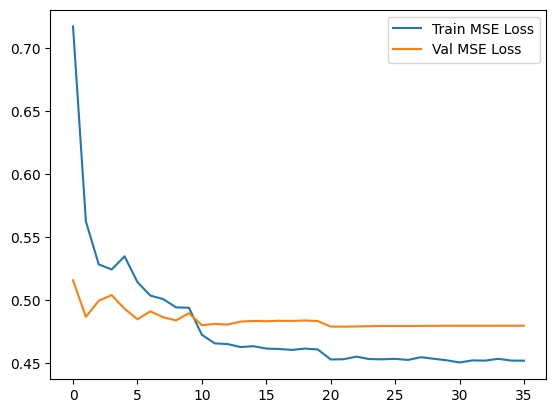

In [9]:
plt.plot(train_results["train_loss"], label="Train MSE Loss")
plt.plot(train_results["val_loss"], label="Val MSE Loss")
plt.legend()
plt.show()

In [11]:
pred_dict = train.evaluate(model=model, val_loader=val_loader)
preds = pred_dict["preds"]
true_energies = pred_dict["true_energies"]

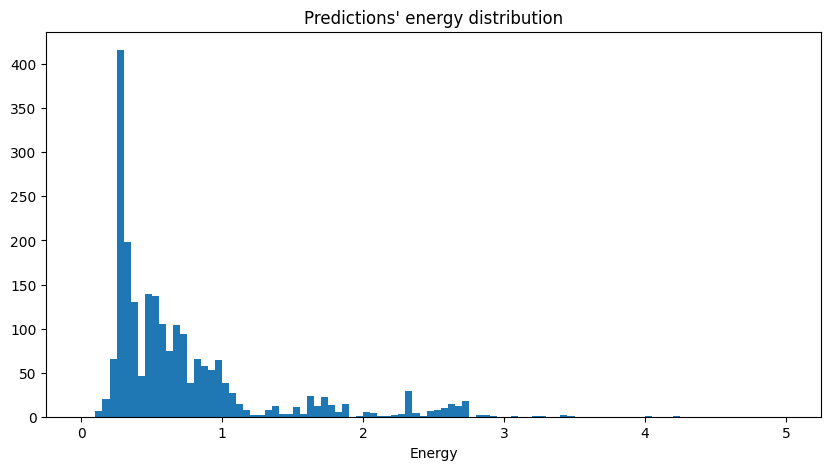

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(preds, bins=100, range=(0,5))
plt.title("Predictions' energy distribution")
plt.xlabel("Energy")
plt.show()

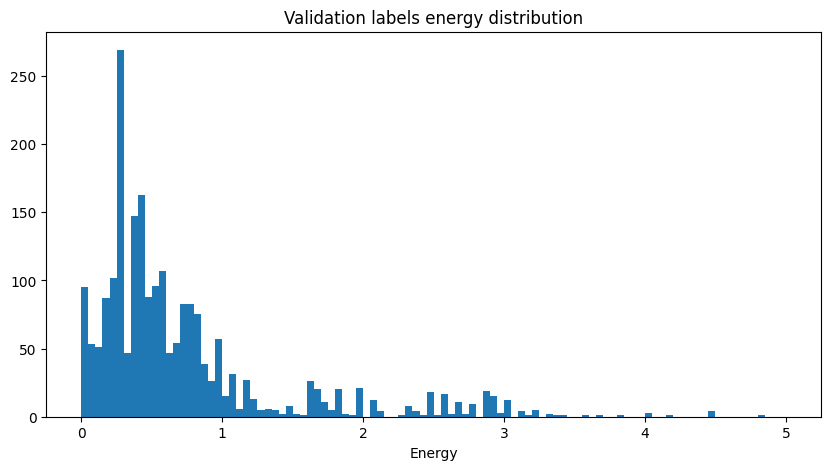

In [61]:
val_labels = true_energies

plt.figure(figsize=(10, 5))
plt.hist(val_labels, bins=100, range=(0,5))
plt.title("Validation labels energy distribution")
plt.xlabel("Energy")
plt.show()

In [13]:
median = np.median(true_energies)
std = np.std(true_energies)

print(f"Labels' median: {median}, Labels' std: {std}")

Labels' median: 0.45734401305543804, Labels' std: 0.86776429262233


In [14]:
mse = round(mean_squared_error(true_energies, preds), 3)
mae = round(mean_absolute_error(true_energies, preds), 3)

print(f"MSE: {mse}")
print(f"MAE: {mae}")

MSE: 0.244
MAE: 0.234


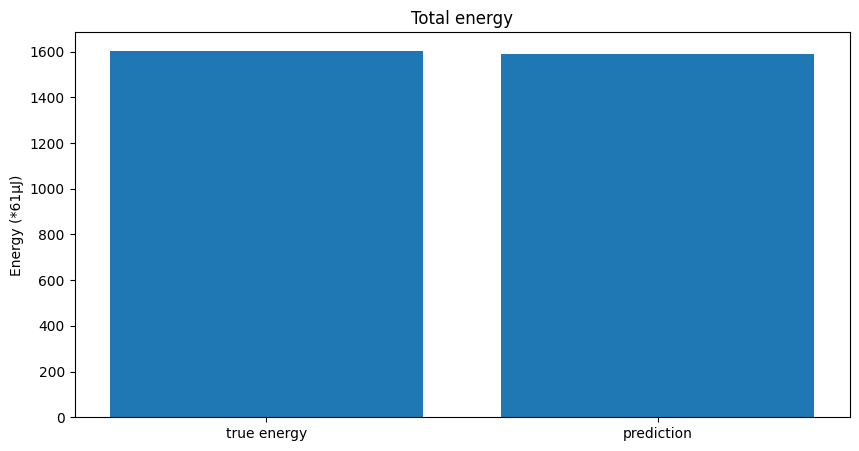

In [15]:
plt.figure(figsize=(10, 5))
plt.title("Total energy")
plt.ylabel("Energy (*61μJ)")
plt.bar(["true energy", "prediction"], [sum(true_energies), sum(preds)])
plt.show()

In [62]:
test_bbs = [[31], [7, 14, 499], [9, 6], [31], [408, 407], [2, 397, 410, 29, 2], [2, 30, 2, 4], [408, 407], [2, 397, 410, 29, 2], [2, 30, 2, 4]]
test_bbs = [torch.tensor(bb).cuda() for bb in test_bbs]
#test_bbs.sort(key=lambda x: x.shape[0], reverse=True)

In [63]:
from torch.nn.utils.rnn import pad_sequence
padded_seq = pad_sequence(test_bbs, batch_first=True, padding_value=0)

In [64]:
padded_seq

tensor([[  2, 397, 410,  29,   2],
        [  2, 397, 410,  29,   2],
        [  2,  30,   2,   4,   0],
        [  2,  30,   2,   4,   0],
        [  7,  14, 499,   0,   0],
        [  9,   6,   0,   0,   0],
        [408, 407,   0,   0,   0],
        [408, 407,   0,   0,   0],
        [ 31,   0,   0,   0,   0],
        [ 31,   0,   0,   0,   0]], device='cuda:0')

In [66]:
hidden_state = model.init_hidden(len(test_bbs))

preds, h_state = model(padded_seq, hidden_state)

In [67]:
preds

tensor([2.7997, 2.7997, 2.0631, 2.0631, 2.3499, 1.5310, 1.8411, 1.8411, 0.7461,
        0.7461], device='cuda:0', grad_fn=<SelectBackward0>)

In [71]:
preds

tensor([2.7997, 2.7997, 2.0631, 2.0631, 2.3499, 1.5310, 1.8411, 1.8411, 0.7461,
        0.7461], device='cuda:0', grad_fn=<SelectBackward0>)